In [1]:
import os
import pandas as pd

#%matplotlib notebook
#import matplotlib.pyplot as plt

%pylab inline

import statistics as st

import numpy as np

from scipy import stats

Populating the interactive namespace from numpy and matplotlib


### Importar series OBJ y REF

In [2]:
def extract_data(ciudad):

    base_dir = os.path.join('.','data')
    output_dir = os.path.join('.','output')

    fuente_OBJ = 'IDEAM'
    fuente_REF = 'NREL'

    serie_csv_OBJ = os.path.join(base_dir,ciudad,fuente_OBJ+'.csv')
    serie_pd_OBJ = pd.read_csv(serie_csv_OBJ, sep = ';', encoding = 'latin-1')

    serie_csv_REF = os.path.join(base_dir,ciudad,fuente_REF+'.csv')
    serie_pd_REF = pd.read_csv(serie_csv_REF, sep = ';', encoding = 'latin-1')

    # Crear una serie independiente para editar después
    serie_csv_COR = os.path.join(base_dir,ciudad,fuente_REF+'.csv')
    serie_pd_COR = pd.read_csv(serie_csv_COR, sep = ';', encoding = 'latin-1')
    
    # Obtener el año mínimo que coincide entre las series & obtener el número de años de la serie más corta
    agno_min = 0
    min_agnos = 0

    if np.min(serie_pd_OBJ['AÑO']) >= np.min(serie_pd_REF['AÑO']):
        agno_min = np.min(serie_pd_OBJ['AÑO'])
    else:
        agno_min = np.min(serie_pd_REF['AÑO'])

    if np.max(serie_pd_OBJ['AÑO']) <= np.max(serie_pd_REF['AÑO']):
        min_agnos = np.max(serie_pd_OBJ['AÑO']) - agno_min +1
    else:
        min_agnos = np.max(serie_pd_REF['AÑO']) - agno_min +1
    
    return serie_pd_OBJ, serie_pd_REF, serie_pd_COR, agno_min, min_agnos

### Función para cortar series

In [3]:
# Param: serie OBJ, serie REF, serie COR, año inicial deseado, número de años, mes inicial deseado, número de meses
def cut_series(serie_horaria,agno_select=0,num_agnos=1,mes_select=1,num_meses=12):
    
    if (agno_select == 0):
        agno_select = np.min(serie_horaria['AÑO'])
        
    agno_final = agno_select + (num_agnos-1)
    mes_final = mes_select + (num_meses-1)

    
    serie_cortada = serie_horaria[(serie_horaria['AÑO'] >= agno_select) &
                                  (serie_horaria['AÑO'] <= agno_final) &
                                  (serie_horaria['MES'] >= mes_select) &
                                  (serie_horaria['MES'] <= mes_final)
                                 ]
    
    #print("El año inicial es: {}".format(agno_select))
    #print("El año final es: {}".format(agno_final))
    #print("El mes inicial es: {}".format(mes_select))
    #print("El mes final es: {}".format(mes_final))
    
    return serie_cortada

### Función para aplicar método MCP

In [4]:
# Param: serie OBJ, serie REF, serie COR, año inicial deseado, número de años, mes inicial deseado, número de meses
def mcp(obj,ref,cor,agno_select=0,num_agnos=1,mes_select=1,num_meses=12):
    
    # Cuando no se ponen los parámetros opcionales, el caso por default es el primer año de las series que coincida
    if agno_select == 0:
        if np.min(obj['AÑO']) >= np.min(ref['AÑO']):
            agno_select = np.min(obj['AÑO'])
        else:
            agno_select = np.min(ref['AÑO'])
    
    # Cortar ambas series al periodo deseado
    obj_cort = cut_series(obj,agno_select,num_agnos,mes_select,num_meses)
    ref_cort = cut_series(ref,agno_select,num_agnos,mes_select,num_meses)
    
    # Obtener el GHI para ambas series cortadas y la serie REF completa
    ghi_obj = obj_cort[list(obj_cort)[-1]]
    ghi_ref = ref_cort[list(ref_cort)[-1]]
    ghi_ref_tot = ref[list(ref)[-1]]
    
    # Obtener medias y desviación estándar
    sigma_obj = st.stdev(ghi_obj)
    sigma_ref = st.stdev(ghi_ref)
    mu_obj = st.mean(ghi_obj)
    mu_ref = st.mean(ghi_ref)
    
    # Aplicar función
    corregida = (mu_obj-((sigma_obj/sigma_ref)*mu_ref))+((sigma_obj/sigma_ref)*ghi_ref_tot)
    
    # Volver todos los datos negativos cero
    for i in range(len(corregida)):
        if corregida[i] < 0:
            corregida[i] = 0
    
    # Cambiar el nombre de la columna
    cor.rename(columns={list(cor)[-1] : 'GHI MCP'}, inplace=True) 
    
    # Meter los datos corregidos a la lista
    cor[list(cor)[-1]] = corregida
    
    return cor

### Calcular el promedio diario mensual y el promedio diario

In [5]:
# Calcular el promedio diario del GHI para el mes
def ghi_diario_mensual(serie_horaria):
    agnos = sorted(serie_horaria['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHIdiario"])
    for agno in agnos:
        for mes in range(1,13):
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                        (serie_horaria['MES'] == mes)]["DIA"].unique())
            ghi_dia = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                            & (serie_horaria["MES"] == mes)),
                                        nombre_energia].sum()/(1000*dias[-1])
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                        "GHIdiario":ghi_dia}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df

# Calcula el GHI promedio para cada dia
def ghi_diario(serie_horaria):
    agnos = sorted(serie_horaria['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIA", "GHI_Diario"])
    for agno in agnos:
        for mes in range(1,13):
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                        (serie_horaria['MES'] == mes)]["DIA"].unique())
            
            for dia in dias:
                ghi_diario = serie_horaria.loc[((serie_horaria["AÑO"] == agno) & 
                                                (serie_horaria["MES"] == mes) & 
                                                (serie_horaria["DIA"] == dia)),nombre_energia].sum()/(1000*24)
                ghi_dict = {"AÑO":agno, "MES":mes, "DIA":dia,
                            "GHI_Diario":ghi_diario}
                ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df

### Preparar datos para graficar

In [6]:
def prepare_data(serie_pd_OBJ, serie_pd_REF, obj_cor, agno_min, min_agnos):
    # IDEAM
    ghi_dia_mes_OBJ = ghi_diario_mensual(serie_pd_OBJ)
    datos_IDEAM = sorted(ghi_dia_mes_OBJ["GHIdiario"])

    # NREL
    nrel_cort = cut_series(serie_pd_REF,agno_min,min_agnos)
    ghi_dia_mes_REF = ghi_diario_mensual(nrel_cort)
    datos_NREL = sorted(ghi_dia_mes_REF["GHIdiario"])

    # CORREGIDO
    nueva_cort = cut_series(obj_cor,agno_min,min_agnos)
    ghi_dia_mes_NEW = ghi_diario_mensual(nueva_cort)
    datos_NEW = sorted(ghi_dia_mes_NEW["GHIdiario"])
    
    return datos_IDEAM, datos_NREL, datos_NEW

In [7]:
def graph_data(ciudad,datos_IDEAM,datos_NREL,datos_NEW):
    output_dir = os.path.join('.','output')
        
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base IDEAM")
    pylab.title(ciudad)
    numdatos = range(len(datos_IDEAM))
    pylab.plot(numdatos,datos_IDEAM/datos_IDEAM[0],'-k', label='IDEAM')
    pylab.plot(numdatos,datos_NREL/datos_IDEAM[0],'-b', label='NREL')
    pylab.plot(numdatos,datos_NEW/datos_IDEAM[0],'-r', label='NEW')
    pylab.legend(loc='upper left')
    #pylab.savefig(os.path.join(output_dir,ciudad+'.png'), dpi=600)
    
    return None

### Error RMSEn

In [80]:
# Param: serie OBJ, serie corregida/nueva cortada
def rmsen(obj,cor):
    
    if(type(obj) != list):
    
        nom_ener_obj = list(obj)[-1]
        nom_ener_cor = list(cor)[-1]

        n = len(cor)
        resta = []
        i_min = cor.first_valid_index() 

        for i in range(n):
            x_obj = obj[nom_ener_obj][i]
            x_cor = cor[nom_ener_cor][i+i_min]

            x = (x_obj - x_cor)**2

            resta.append(x)

        error = np.sqrt((1/n)*sum(resta))/(np.max(obj[nom_ener_obj]) - np.min(obj[nom_ener_obj]))
        
    else:

        n = len(cor)
        resta = [] 

        for i in range(n):
            x_obj = obj[i]
            x_cor = cor[i]

            x = (x_obj - x_cor)**2

            resta.append(x)

        error = np.sqrt((1/n)*sum(resta))/(np.max(obj) - np.min(obj))
        
    print("El error RMSEn es: {0:.3f}%".format(error*100))

    return error        

### Error MBE

In [81]:
# Param: serie OBJ, serie corregida/nueva cortada
def mbe(obj,cor):
    
    if(type(obj) != list):
    
        nom_ener_obj = list(obj)[-1]
        nom_ener_cor = list(cor)[-1]

        n = len(cor)
        resta = []

        i_min = cor.first_valid_index() 

        for i in range(n):
            x_obj = obj[nom_ener_obj][i]
            x_cor = cor[nom_ener_cor][i+i_min]

            x = (x_cor - x_obj)

            resta.append(x)

        error = sum(resta)/sum(obj[nom_ener_obj])
        
    else:
        
        n = len(cor)
        resta = []

        for i in range(n):
            x_obj = obj[i]
            x_cor = cor[i]

            x = (x_cor - x_obj)

            resta.append(x)

        error = sum(resta)/sum(obj)
        
    print("El error MBE es: {0:.3f}%".format(error*100))
    
    return error

### Error KSI%

In [84]:
def ksi_err(obj,serie):
    
    s, p = stats.ks_2samp(obj,serie)
    
    print("El P-Value es: {}".format(p))
    
    return s, p

### ENFICC

In [85]:
def enficc(serie):
    
    percentil = 0.01
    enficc = np.percentile(serie,(1-percentil)*100)
    print('La ENFICC 99% es: {0:.3f}'.format(enficc))
    
    return enficc

-------------------------
# Informe
--------------------------

A continuación se hace uso de todas las funciones anteriores para analizar la eficacia del método de corrección implementado. Se va a utilizar el año 2013 como base para todas las ubicaciones y se va a escoger otro año para comparar el efecto. 

Adicionalmente, se va a utilizar Valledupar como una ubicación de "control" para la cual se va a estudiar el impacto de usar periodos menores y mayores a un año para la corrección de los datos. 

#### Índice

1. Barranquilla
    1. 2013
    2. otro
    3. Análisis
2. Cali
    1. 2013
    2. otro
    3. Análisis
3. Carmen de Bolivar
    1. 2013
    2. otro
    3. Análisis
4. Medellin
    1. 2013
    2. otro
    3. Análisis
5. Santa Marta
    1. 2013
    2. otro
    3. Análisis
6. Sucre
    1. 2013
    2. otro
    3. Análisis
7. Uribia
    1. 2013
    2. otro
    3. Análisis
8. Valledupar
    1. 2013 - 1 mes
    2. 2013 - 3 meses
    3. 2013 - 6 meses
    4. 2013 - 9 meses
    5. 2013 - 1 año
    6. 2013 - 2 años

## Barranquilla

In [277]:
# Importar datos CSV
bar_OBJ, bar_REF, bar_EXTRA, bar_min_agno, bar_agnos = extract_data('Barranquilla')

print("Primer año: ", bar_min_agno)
print("Último año: ", bar_min_agno+bar_agnos-1)

Primer año:  2010
Último año:  2015


### 2013

In [278]:
# Aplicar corrección MCP
bar1_COR = mcp(bar_OBJ,bar_REF,bar_EXTRA,2013)

In [279]:
# Preparar datos
bar1_IDEAM, bar1_NREL, bar1_NEW = prepare_data(bar_OBJ,bar_REF,bar1_COR,bar_min_agno,bar_agnos)

In [280]:
# Cortar serie corregida para errores
bar1_COR_cut = cut_series(bar1_COR,bar_min_agno,bar_agnos)
bar1_NREL_cut = cut_series(bar_REF,bar_min_agno,bar_agnos)

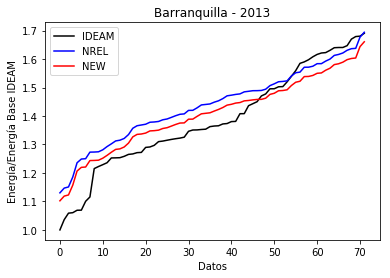

In [335]:
# Graficar datos
graph_data('Barranquilla - 2013',bar1_IDEAM,bar1_NREL,bar1_NEW)

In [336]:
# Calcular Errores - NREL
print('Errores NREL')
bar1_rmsen_nrel = rmsen(bar_OBJ,bar1_NREL_cut)
bar1_mbe_nrel = mbe(bar_OBJ,bar1_NREL_cut)
bar1_stat_nrel, bar1_p_nrel = ksi_err(bar1_IDEAM,bar1_NREL)

print('\n')

# Calcular Errores - NEW
print('Errores NEW')
bar1_rmsen_new = rmsen(bar_OBJ,bar1_COR_cut)
bar1_mbe_new = mbe(bar_OBJ,bar1_COR_cut)
bar1_stat_new, bar1_p_new = ksi_err(bar1_IDEAM,bar1_NEW)

Errores NREL
El error RMSEn es: 10.676%
El error MBE es: 3.699%
El P-Value es: 0.005966860647227961


Errores NEW
El error RMSEn es: 10.595%
El error MBE es: 1.452%
El P-Value es: 0.17132623247456719


In [337]:
# Calcular ENFICC
print('- IDEAM')
bar1_enficc_IDEAM = enficc(bar1_IDEAM)
print('- NREL')
bar1_enficc_NREL = enficc(bar1_NREL)
print('- NEW')
bar1_enficc_NEW = enficc(bar1_NEW)

- IDEAM
La ENFICC 99% es: 6.829
- NREL
La ENFICC 99% es: 6.823
- NEW
La ENFICC 99% es: 6.688


### 2015

In [338]:
# Aplicar corrección MCP
bar2_COR = mcp(bar_OBJ,bar_REF,bar_EXTRA,2015)

In [339]:
# Preparar datos
bar2_IDEAM, bar2_NREL, bar2_NEW = prepare_data(bar_OBJ,bar_REF,bar2_COR,bar_min_agno,bar_agnos)

In [340]:
# Cortar serie corregida para errores
bar2_COR_cut = cut_series(bar2_COR,bar_min_agno,bar_agnos)
bar2_NREL_cut = cut_series(bar_REF,bar_min_agno,bar_agnos)

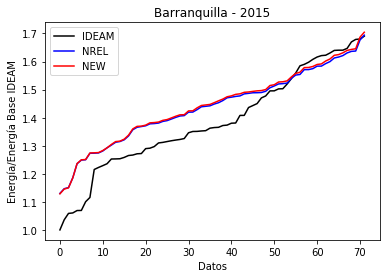

In [341]:
# Graficar datos
graph_data('Barranquilla - 2015',bar2_IDEAM,bar2_NREL,bar2_NEW)

In [342]:
# Calcular Errores - NEW
print('Errores NEW')
bar2_rmsen_new = rmsen(bar_OBJ,bar2_COR_cut)
bar2_mbe_new = mbe(bar_OBJ,bar2_COR_cut)
bar2_stat_new, bar2_p_new = ksi_err(bar2_IDEAM,bar2_NEW)

Errores NEW
El error RMSEn es: 10.779%
El error MBE es: 4.042%
El P-Value es: 0.003287791631799178


In [343]:
# Calcular ENFICC
print('- NEW')
bar2_enficc_NEW = enficc(bar2_NEW)

- NEW
La ENFICC 99% es: 6.864


### Análisis

-----------------
## Cali

In [344]:
# Importar datos CSV
cal_OBJ, cal_REF, cal_EXTRA, cal_min_agno, cal_agnos = extract_data('Cali')

### 2013

In [345]:
# Aplicar corrección MCP
cal1_COR = mcp(cal_OBJ,cal_REF,cal_EXTRA,2013)

In [346]:
# Preparar datos
cal1_IDEAM, cal1_NREL, cal1_NEW = prepare_data(cal_OBJ,cal_REF,cal1_COR,cal_min_agno,cal_agnos)

In [347]:
# Cortar serie corregida para errores
cal1_COR_cut = cut_series(cal1_COR,cal_min_agno,cal_agnos)
cal1_NREL_cut = cut_series(cal_REF,cal_min_agno,cal_agnos)

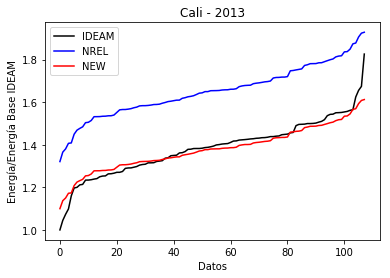

In [348]:
# Graficar datos
graph_data('Cali - 2013',cal1_IDEAM,cal1_NREL,cal1_NEW)

In [349]:
# Calcular Errores - NREL
print('Errores NREL')
cal1_rmsen_nrel = rmsen(cal_OBJ,cal1_NREL_cut)
cal1_mbe_nrel = mbe(cal_OBJ,cal1_NREL_cut)
cal1_stat_nrel, cal1_p_nrel = ksi_err(cal1_IDEAM,cal1_NREL)

print('\n')

# Calcular Errores - NEW
print('Errores NEW')
cal1_rmsen_new = rmsen(cal_OBJ,cal1_COR_cut)
cal1_mbe_new = mbe(cal_OBJ,cal1_COR_cut)
cal1_stat_new, cal1_p_new = ksi_err(cal1_IDEAM,cal1_NEW)

Errores NREL
El error RMSEn es: 11.969%
El error MBE es: 19.255%
El P-Value es: 1.8189145374614879e-28


Errores NEW
El error RMSEn es: 10.100%
El error MBE es: -0.465%
El P-Value es: 0.39164879222863963


In [350]:
# Calcular ENFICC
print('- IDEAM')
cal1_enficc_IDEAM = enficc(cal1_IDEAM)
print('- NREL')
cal1_enficc_NREL = enficc(cal1_NREL)
print('- NEW')
cal1_enficc_NEW = enficc(cal1_NEW)

- IDEAM
La ENFICC 99% es: 5.325
- NREL
La ENFICC 99% es: 6.121
- NEW
La ENFICC 99% es: 5.115


### 2015

In [351]:
# Aplicar corrección MCP
cal2_COR = mcp(cal_OBJ,cal_REF,cal_EXTRA,2015)

In [352]:
# Preparar datos
cal2_IDEAM, cal2_NREL, cal2_NEW = prepare_data(cal_OBJ,cal_REF,cal2_COR,cal_min_agno,cal_agnos)

In [353]:
# Cortar serie corregida para errores
cal2_COR_cut = cut_series(cal2_COR,cal_min_agno,cal_agnos)
cal2_NREL_cut = cut_series(cal_REF,cal_min_agno,cal_agnos)

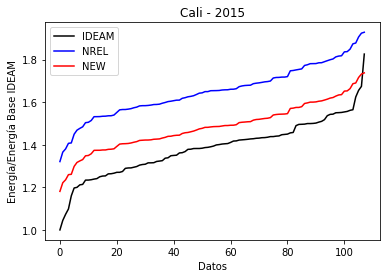

In [354]:
# Graficar datos
graph_data('Cali - 2015',cal2_IDEAM,cal2_NREL,cal2_NEW)

In [355]:
# Calcular Errores - NEW
print('Errores NEW')
cal2_rmsen_new = rmsen(cal_OBJ,cal2_COR_cut)
cal2_mbe_new = mbe(cal_OBJ,cal2_COR_cut)
cal2_stat_new, cal2_p_new = ksi_err(cal2_IDEAM,cal2_NEW)

Errores NEW
El error RMSEn es: 10.597%
El error MBE es: 7.101%
El P-Value es: 1.901476303606619e-06


In [356]:
# Calcular ENFICC
print('- NEW')
cal2_enficc_NEW = enficc(cal2_NEW)

- NEW
La ENFICC 99% es: 5.510


### Análisis

---------------
## Carmen de Bolivar

In [357]:
# Importar datos CSV
car_OBJ, car_REF, car_EXTRA, car_min_agno, car_agnos = extract_data('Carmendebolivar')

print("Primer año: ", car_min_agno)
print("Último año: ", car_min_agno+car_agnos-1)

Primer año:  2007
Último año:  2015


### 2013

In [358]:
# Aplicar corrección MCP
car1_COR = mcp(car_OBJ,car_REF,car_EXTRA,2013)

In [359]:
# Preparar datos
car1_IDEAM, car1_NREL, car1_NEW = prepare_data(car_OBJ,car_REF,car1_COR,car_min_agno,car_agnos)

In [360]:
# Cortar serie corregida para errores
car1_COR_cut = cut_series(car1_COR,car_min_agno,car_agnos)
car1_NREL_cut = cut_series(car_REF,car_min_agno,car_agnos)

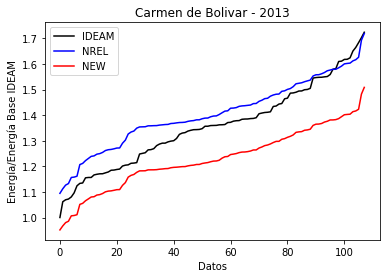

In [361]:
# Graficar datos
graph_data('Carmen de Bolivar - 2013',car1_IDEAM,car1_NREL,car1_NEW)

In [362]:
# Calcular Errores - NREL
print('Errores NREL')
car1_rmsen_nrel = rmsen(car_OBJ,car1_NREL_cut)
car1_mbe_nrel = mbe(car_OBJ,car1_NREL_cut)
car1_stat_nrel, car1_p_nrel = ksi_err(car1_IDEAM,car1_NREL)

print('\n')

# Calcular Errores - NEW
print('Errores NEW')
car1_rmsen_new = rmsen(car_OBJ,car1_COR_cut)
car1_mbe_new = mbe(car_OBJ,car1_COR_cut)
car1_stat_new, car1_p_new = ksi_err(car1_IDEAM,car1_NEW)

Errores NREL
El error RMSEn es: 10.076%
El error MBE es: 3.603%
El P-Value es: 0.007923678503375256


Errores NEW
El error RMSEn es: 9.872%
El error MBE es: -9.461%
El P-Value es: 1.953104902978325e-07


In [363]:
# Calcular ENFICC
print('- IDEAM')
car1_enficc_IDEAM = enficc(car1_IDEAM)
print('- NREL')
car1_enficc_NREL = enficc(car1_NREL)
print('- NEW')
car1_enficc_NEW = enficc(car1_NEW)

- IDEAM
La ENFICC 99% es: 6.512
- NREL
La ENFICC 99% es: 6.461
- NEW
La ENFICC 99% es: 5.657


### Otro

In [364]:
# Aplicar corrección MCP
car2_COR = mcp(car_OBJ,car_REF,car_EXTRA,2007)

In [365]:
# Preparar datos
car2_IDEAM, car2_NREL, car2_NEW = prepare_data(car_OBJ,car_REF,car2_COR,car_min_agno,car_agnos)

In [366]:
# Cortar serie corregida para errores
car2_COR_cut = cut_series(car2_COR,car_min_agno,car_agnos)
car2_NREL_cut = cut_series(car_REF,car_min_agno,car_agnos)

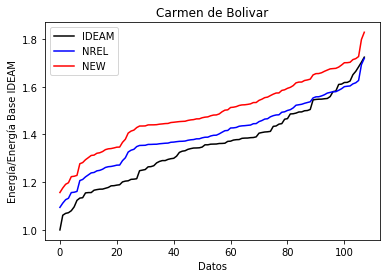

In [367]:
# Graficar datos
graph_data('Carmen de Bolivar',car2_IDEAM,car2_NREL,car2_NEW)

In [368]:
# Calcular Errores - NEW
print('Errores NEW')
car2_rmsen_new = rmsen(car_OBJ,car2_COR_cut)
car2_mbe_new = mbe(car_OBJ,car2_COR_cut)
car2_stat_new, car2_p_new = ksi_err(car2_IDEAM,car2_NEW)

Errores NEW
El error RMSEn es: 10.678%
El error MBE es: 9.891%
El P-Value es: 7.503004256882889e-11


In [369]:
# Calcular ENFICC
print('- NEW')
car2_enficc_NEW = enficc(car2_NEW)

- NEW
La ENFICC 99% es: 6.862
